In [34]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [4]:
# Query for all the films that were rented in the month of May 2005

query = '''SELECT film_id, count(*) as rental_count
from sakila.rental r
inner join sakila.inventory i
using (inventory_id)
WHERE rental_date BETWEEN '2005-05-01 00:00:00' AND '2005-05-31 23:23:59'
group by film_id
'''

rental_combined = pd.read_sql_query(query, engine) #table 1
rental_combined.head(10)

,film_id,rental_count
0,80,1
1,333,2
2,373,2
3,535,4
4,450,5
5,613,2
6,870,3
7,510,2
8,565,1
9,396,3


In [5]:
#Query - all film data including film category and storing them in films_data dataframe

query = '''SELECT *
from sakila.film f
inner join sakila.film_category fc
using (film_id)
inner join sakila.category c
using (category_id)
'''

films_data = pd.read_sql_query(query, engine) #table 2
films_data.head()

,category_id,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,last_update,name,last_update
0,1,19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,1,None,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42,2006-02-15 05:07:09,Action,2006-02-15 04:46:27
1,1,21,AMERICAN CIRCUS,A Insightful Drama of a Girl And a Astronaut w...,2006,1,None,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",2006-02-15 05:03:42,2006-02-15 05:07:09,Action,2006-02-15 04:46:27
2,1,29,ANTITRUST TOMATOES,A Fateful Yarn of a Womanizer And a Feminist w...,2006,1,None,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",2006-02-15 05:03:42,2006-02-15 05:07:09,Action,2006-02-15 04:46:27
3,1,38,ARK RIDGEMONT,A Beautiful Yarn of a Pioneer And a Monkey who...,2006,1,None,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",2006-02-15 05:03:42,2006-02-15 05:07:09,Action,2006-02-15 04:46:27
4,1,56,BAREFOOT MANCHURIAN,A Intrepid Story of a Cat And a Student who mu...,2006,1,None,6,2.99,129,15.99,G,"Trailers,Commentaries",2006-02-15 05:03:42,2006-02-15 05:07:09,Action,2006-02-15 04:46:27


In [6]:
films_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   category_id           1000 non-null   int64         
 1   film_id               1000 non-null   int64         
 2   title                 1000 non-null   object        
 3   description           1000 non-null   object        
 4   release_year          1000 non-null   int64         
 5   language_id           1000 non-null   int64         
 6   original_language_id  0 non-null      object        
 7   rental_duration       1000 non-null   int64         
 8   rental_rate           1000 non-null   float64       
 9   length                1000 non-null   int64         
 10  replacement_cost      1000 non-null   float64       
 11  rating                1000 non-null   object        
 12  special_features      1000 non-null   object        
 13  last_update        

In [7]:
films_data.columns

Index(['category_id', 'film_id', 'title', 'description', 'release_year',
       'language_id', 'original_language_id', 'rental_duration', 'rental_rate',
       'length', 'replacement_cost', 'rating', 'special_features',
       'last_update', 'last_update', 'name', 'last_update'],
      dtype='object')

In [8]:
# Only using the columns which are of interest

films_data = films_data[['film_id', 'release_year','rental_duration', 'rental_rate',
       'length', 'replacement_cost', 'rating', 'name']]

In [9]:
# changing last column name to category
films_data.columns = ['film_id', 'release_year', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'category']

In [10]:
films_data.head()

,film_id,release_year,rental_duration,rental_rate,length,replacement_cost,rating,category
0,19,2006,6,0.99,113,20.99,PG,Action
1,21,2006,3,4.99,129,17.99,R,Action
2,29,2006,5,2.99,168,11.99,NC-17,Action
3,38,2006,6,0.99,68,25.99,NC-17,Action
4,56,2006,6,2.99,129,15.99,G,Action


In [11]:
#Merging table 1 and table 2
new_data = pd.merge(films_data, rental_combined, how='outer', on='film_id')

In [12]:
new_data.head()

,film_id,release_year,rental_duration,rental_rate,length,replacement_cost,rating,category,rental_count
0,19,2006,6,0.99,113,20.99,PG,Action,1.0
1,21,2006,3,4.99,129,17.99,R,Action,2.0
2,29,2006,5,2.99,168,11.99,NC-17,Action,2.0
3,38,2006,6,0.99,68,25.99,NC-17,Action,NaN
4,56,2006,6,2.99,129,15.99,G,Action,1.0


In [13]:
#Filling nans with 0
new_data['rental_count'].fillna(0, inplace=True)

In [15]:
# rental_count is going to be the target and so it needs to have either 1 or o (binary category)
new_data['rental_count'] = new_data['rental_count'].apply(lambda row: 1 if row > 0 else 0)

In [16]:
new_data['rental_count'].value_counts()

1    686
0    314
Name: rental_count, dtype: int64

# X-Y split

In [18]:
y = new_data['rental_count']
X = new_data.drop(['rental_count'], axis=1)

#Train-Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [19]:
#Splitting X_train into numerical and categorical and then transforming

#1. Numerical data for X_train

X_train_num = X_train._get_numeric_data() 

#Using MinMaxScaler for X_train

transformer = MinMaxScaler().fit(X_train_num)
X_train_normalized = transformer.transform(X_train_num)

X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns) 
X_train_norm.head()


,film_id,release_year,rental_duration,rental_rate,length,replacement_cost
0,0.343343,0.0,0.00,0.0,0.949640,0.95
1,0.329329,0.0,1.00,1.0,0.474820,0.65
2,0.740741,0.0,1.00,0.0,0.251799,0.95
3,0.979980,0.0,0.25,1.0,0.208633,0.15
4,0.541542,0.0,0.00,0.5,0.043165,0.95


In [20]:
#2.Categorical data for X_train

X_train_categorical = X_train.select_dtypes(include = np.object)

#OneHot encoding categoricals X_train

encoder = OneHotEncoder(drop='first').fit(X_train_categorical) 
encoded = encoder.transform(X_train_categorical).toarray()
encoded_columns = OneHotEncoder(drop='first').fit(X_train_categorical).get_feature_names(input_features=X_train_categorical.columns) # this allows us to get the columns names for our encoded array

X_train_cat = pd.DataFrame(encoded, columns = encoded_columns)
X_train_cat.head(20)

C:\Users\A.M\AppData\Local\Temp\ipykernel_14700\1607982632.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)
C:\Users\A.M\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
#Concatenate both dataframes for X_train
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [22]:
X_train_transformed

array([[0.34334334, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32932933, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74074074, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18718719, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21821822, 0.        , 0.75      , ..., 0.        , 0.        ,
        0.        ],
       [0.34934935, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [23]:
#Logistic Regression - For X_train transformed
classification = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(X_train_transformed, y_train)

In [24]:
#X_test scaling for numerical data

X_test_num = X_test.select_dtypes(include = np.number)

# we use the Minmaxscaler transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm

,0,1,2,3,4,5
0,0.830831,0.0,0.50,0.0,0.661871,0.55
1,0.810811,0.0,0.25,0.5,0.100719,1.00
2,0.895896,0.0,0.00,0.0,0.798561,0.05
3,0.945946,0.0,0.00,1.0,0.705036,0.25
4,0.283283,0.0,0.50,1.0,0.223022,0.70
...,...,...,...,...,...,...
195,0.328328,0.0,0.25,0.5,0.122302,0.30
196,0.950951,0.0,0.75,0.0,0.230216,0.95
197,0.836837,0.0,0.25,0.5,0.280576,0.50
198,0.832833,0.0,0.50,0.0,0.633094,0.55


In [25]:
#X_test Onehotencoding for categorical

X_test_categorical = X_test.select_dtypes(include = object)
encoder = OneHotEncoder(drop='first').fit(X_test_categorical) 
encoded = encoder.transform(X_test_categorical).toarray() 
encoded_columns = OneHotEncoder(drop='first').fit(X_test_categorical).get_feature_names(input_features=X_test_categorical.columns) # this allows us to get the columns names for our encoded array

X_test_cat = pd.DataFrame(encoded, columns = encoded_columns)
X_test_cat.head(20)

C:\Users\A.M\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
# combining both transformed X_tests
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [27]:
X_test_transformed

array([[0.83083083, 0.        , 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.81081081, 0.        , 0.25      , ..., 0.        , 0.        ,
        1.        ],
       [0.8958959 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.83683684, 0.        , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.83283283, 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.78978979, 0.        , 0.75      , ..., 0.        , 0.        ,
        0.        ]])

In [28]:
#Logistic regression score
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.695

In [29]:
print(y_test.value_counts())

1    139
0     61
Name: rental_count, dtype: int64


In [30]:
pd.Series(predictions).value_counts()

1    198
0      2
dtype: int64

In [32]:
#Confusion matrix
print(confusion_matrix(y_test, predictions))

[[  1  60]
 [  1 138]]


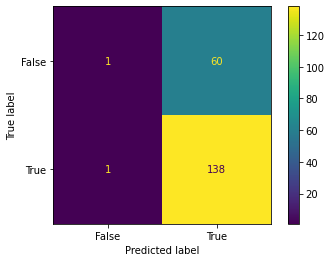

In [35]:
#Source: https://www.w3schools.com/python/python_ml_confusion_matrix.asp

confusion_matrix = metrics.confusion_matrix(y_test, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()